# 1. Player Performance Quatification

---

### Importing Required Libraries

In [12]:
import numpy as np                                           # linear algebra
import pandas as pd                                          # data processing, CSV file I/O
import matplotlib.pyplot as plt                              # Data Visualization 
import seaborn as sns                                        # Python library for Visualization
from sklearn import preprocessing                            # Library for data pre-processing
from sklearn.model_selection import train_test_split         # To split dataset into training and testing
from sklearn.cluster import KMeans                           # K-Means clustering model
from sklearn.neighbors import KNeighborsClassifier           # KNN-Classification model
from sklearn.metrics import accuracy_score                   # Library to calculate accuracy of a model

max = 9223372036854775807


### Defining Functions To Evaluate Batting Performance


In [13]:
# defining calculation functions

def calcBA(pruns, pinnings, pnotout):
    ba = pruns / (pinnings - pnotout)
    return ba


def calcBS(pruns, pbfaced):
    bs = pruns / pbfaced
    return bs


def calcMRA(pinnings, pnotout, pbfaced):
    mra = (pinnings - pnotout) / pbfaced
    return mra


def calcBRPI(pfours, psixes, pinnings):
    brpi = (4*pfours + 6*psixes) / pinnings
    return brpi


def calcBatOutRate(pinnings, pnotout, pbfaced):
    outrate = pd.Series(np.array([max])) if float(pbfaced) == 0 else (pinnings - pnotout) / pbfaced
    return outrate

def calcGenBatAvg(truns, twickets):
    return truns / twickets


def calcGenBatOutRate(twickets, tbfaced):
    return twickets / tbfaced


def calcGenStrikeRate(truns, tbfaced):
    return truns / tbfaced


def calcBatAGR(tpRuns, tpBallfaced, tpOutRate, gBatAvg, gStrikeRate, gOutRate):
    agr = ((tpRuns - gStrikeRate * tpBallfaced) + gBatAvg * tpBallfaced * (gOutRate - tpOutRate))
    return agr


def calcBatRankingIndex(agr, gBatAvg):
    return agr / (10 * gBatAvg)



### Defining Functions To Evaluate Bowling Performance

In [14]:

def calcBowlAvg(runsGiven, wicketsTaken):
    return runsGiven / wicketsTaken


def calcBowlSR(ballsBowled, wicketsTaken):
    return ballsBowled / wicketsTaken


def calcBowlER(runsGiven, oversBowled):
    return runsGiven / oversBowled


def calcBowlOutRate(wicketsTaken, ballsBowled):
    outr = pd.Series(np.array([0])) if float(ballsBowled) == 0 else wicketsTaken / ballsBowled
    return outr


def calcBowlAGR(tpRunsGiven, tpOvers, tpOutrate, gBowlAvg, gBowlSR, gBowlOutrate ):
    balls = int(tpOvers) * 6 + 10 * (tpOvers - int(tpOvers))
    bowlagr = (gBowlSR * balls - tpRunsGiven) + gBowlAvg * balls * (tpOutrate - gBowlOutrate)
    
#     print(bowlagr[0])
#     if tpOvers[0] == 0.1:
#         print('-------------------------------')
#         print('tpRunsGiven  :',tpRunsGiven[0]) 
#         print('tpballs      :', balls[0])
#         print('tpOutrate    :', tpOutrate[0])
#         print('gBowlAvg     :', gBowlAvg[0]) 
#         print('gBowlSR      :', gBowlSR[0])
#         print('gBowlOutrate :',  gBowlOutrate[0])
#         print('-------------------------------')
#         print('bowlAGR      : ', bowlagr)
        
    return bowlagr


def calcBowlRI(bowlAGR, gBowlAvg):
    bri = bowlAGR / (10 * gBowlAvg)
    
#     if bri[0] == 0:
#         print('-------------------------------')
#         print('bowlagr  : ', bowlAGR[0] )
#         print('gbowlAvg : ', gBowlAvg[0])
#         print('-------------------------------')
    
    return bowlAGR / (10 * gBowlAvg)

### Defining Functions To Calculate Generic Tournament Parameters

In [15]:
# generic tournament parameters

def calcGenBowlAvg(totalRunsGiven, totalWicketsTaken):
    return totalRunsGiven / totalWicketsTaken


def calcGenBowlOutRate(totalWicketsTaken, totalOvers):
    balls = int(totalOvers) * 6 + 10 * (totalOvers - int(totalOvers))
    return totalWicketsTaken / balls


def calcGenBowlSR(totalRunsGiven, totalOvers):
    balls = int(totalOvers) * 6 + 10 * (totalOvers - int(totalOvers))
    return  totalRunsGiven / balls



### Defining Function To Claculate Series-wise Batting and Bowling Indexes for All Players 

In [16]:
def calcIndexes(srec):

    series = list(dict.fromkeys(srec["series_code"]).keys())

    # trecord : dataframe for tournament overall performance
    # precord : dataframe for player specific performance in tournament
    # tplayer: dataframe for recording total runs, ballfaced etc for player

    trecord = pd.DataFrame()
    precord = pd.DataFrame()
    tplayer = pd.DataFrame()
    pindexes = pd.DataFrame()

    tournamentPerformance = dict()

    for sr in series[:]:
        tdf = srec[srec["series_code"] == sr]

        ttotal = tdf.drop(['series_code', 'match_code', 'pid', 'name'], axis = 1)

        ttotal = pd.DataFrame(ttotal.sum(axis = 0))
        
        ttballfaced      = ttotal.at['ballfaced', 0]
        ttnotout         = ttotal.at['ballfaced', 0]
        ttruns           = ttotal.at['runs', 0]
        ttwickets_taken  = ttotal.at['wickets_taken', 0]
        ttruns_given     = ttotal.at['runs_given', 0]
        ttovers          = ttotal.at['overs', 0]

        gBatAvg = calcGenBatAvg(ttruns, ttwickets_taken)
        gBatOutRate = calcGenBatOutRate(ttwickets_taken, ttballfaced)
        gStrikeRate = calcGenStrikeRate(ttruns, ttballfaced)

        gBowlAvg = calcBowlAvg(ttruns_given, ttwickets_taken)
        gBowlOutrate = calcGenBowlOutRate(ttwickets_taken, ttovers)
        gBowlSR = calcGenBowlSR(ttruns_given, ttovers)

        players = list()
        for pl in set(tdf["pid"]):
            if pl > 0:
                players.append(pl)

        for player in players[:]:


            ptdf = tdf[tdf['pid'] == player].drop(['series_code', 'match_code', 'pid', 'name'], axis = 1)

            btinnings = np.count_nonzero(ptdf['ballfaced']);
            bwinnings = np.count_nonzero(ptdf['overs']);

            p = pd.DataFrame(ptdf.sum(axis = 0))
    
            pballfaced      = p.at['ballfaced', 0]
            pnotout         = p.at['notout', 0]
            pruns           = p.at['runs', 0]
            pwickets_taken  = p.at['wickets_taken', 0]
            pruns_given     = p.at['runs_given', 0]
            povers          = p.at['overs', 0]
            
            
            if btinnings != 0:

                batOutRate = calcBatOutRate(btinnings, pnotout, pballfaced)
                batAGR = calcBatAGR(pruns, pballfaced, batOutRate, gBatAvg, gStrikeRate, gBatOutRate)
                batRI = calcBatRankingIndex(batAGR, gBatAvg)
                
            else:
                batOutRate = batAGR = batRI = None
                
            if bwinnings != 0:
                
                bowlOutRate = calcBowlOutRate(pwickets_taken, povers)
                bowlAGR = calcBowlAGR(pruns_given, povers, bowlOutRate, gBowlAvg, gBowlSR, gBowlOutrate)
                bowlRI = calcBowlRI(bowlAGR, gBowlAvg)
                
            else:
                bowlOutRate = bowlAGR = bowlRI = None
            
            pRI = {
                'series_code' : sr,
                'pid'    : player,
                'batRI'  : batRI,
                'bowlRI' : bowlRI
            }

            pindexes = pindexes.append(pRI, ignore_index = True)
    return pindexes


### Defining Function To Claculate **Average** of Series-wise Batting and Bowling Indexes for All Players 

In [17]:
def calcAvgRI(data):
    rdata = pd.DataFrame()
    for player in set(data.pid):
        p= data[data['pid'] == player]
        ser = len(p)
        p = p.drop(['pid', 'series_code'], axis = 1 )
        p = pd.DataFrame(p.mean(axis = 0))
        p = p.swapaxes('index', 'columns')

        p.insert(0, 'pid', player)
        p.insert(0, 'series_played', ser)
        rdata = rdata.append(p)
        rdata = rdata.reset_index(drop = True)
    return rdata

### Defining function to return top n batting and bowling indexes

In [18]:
def getMaxIndexes(idata, n):
    ret = pd.DataFrame()
    
    tmp = idata.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    ret['MaxBatRI'] = tmp['batRI']
    
    tmp = idata.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    ret['MaxBowlRI'] = tmp['bowlRI']
    
    return ret.head(n)


def getMinIndexes(idata, n):
    ret = pd.DataFrame()
    
    tmp = idata.sort_values(['batRI']).reset_index(drop=True)
    ret['MinBatRI'] = tmp['batRI']
    
    tmp = idata.sort_values(['bowlRI']).reset_index(drop=True)
    ret['MinBowlRI'] = tmp['bowlRI']
    
    return ret.head(n)

### Defining functions to get min allowed indexes

In [19]:
def getMinAllowedBatRI(pindx, cons):
    minVals = getMinIndexes(pindx, 1)
    minBatRI = minVals['MinBatRI'].at[0] - cons
    return minBatRI


def getMinAllowedBowlRI(pindx, cons):
    minVals = getMinIndexes(pindx, 1)
    minBowlRI = minVals['MinBowlRI'].at[0] - cons
    return minBowlRI

### Defining functions for index range manipulations

In [28]:
def weight_alpha(pindexes, a):
    
    x1 = pindexes['batRI'].values
    y1 = pindexes['bowlRI'].values
    for i in range(len(x1)):
        if(x1[i]>=0):
            x1[i]=x1[i]*(a/100)
        else:
            x1[i]=x1[i]+(x1[i]*((100-a)/100))
    for j in range(len(y1)):
        if(y1[j]>=0):
            y1[j]=y1[j]*(a/100)
        else:
            y1[j]=y1[j]+(y1[j]*((100-a)/100))
            

def modify(pindexes, mul):
    
    x1 = pindexes['batRI'].values
    y1 = pindexes['bowlRI'].values
    
    for i in range(len(x1)):
        x1[i]=x1[i]*mul
        y1[i]=y1[i]*mul


### Defining function to select state-wise top n players

In [30]:
def selStateWiseTopN(stateplayers, nbats, nbowls):
    sel = pd.DataFrame()
    
    sbt = stateplayers.sort_values(['team', 'batRI'], ascending = False).reset_index(drop = True)
    sbl = stateplayers.sort_values(['team', 'bowlRI'], ascending = False).reset_index(drop = True)
    
    for state in set(stateplayers.team):
        
        tsbt = sbt[sbt.team == state]
        
        sel = sel.append(tsbt.head(nbats), ignore_index=True)
            
        tsbl = sbl[sbl.team == state]
        sel = sel.append(tsbl.head(nbowls), ignore_index=True)
            
    sel = sel.drop_duplicates(subset='pid', keep='first', inplace=False)
    return sel


def selOverallTopN(stateplayers, nbats, nbowls):
    sel = pd.DataFrame()
    
    sbt = stateplayers.sort_values(['batRI', 'team'], ascending = False).reset_index(drop = True)
    sbl = stateplayers.sort_values(['bowlRI', 'team'], ascending = False).reset_index(drop = True)

    sel = sel.append(sbt.head(nbats), ignore_index=True)
    
    sel = sel.append(sbl.head(nbowls), ignore_index=True)
            
    sel = sel.drop_duplicates(subset='pid', keep='first', inplace=False)
    
    return sel


*******

---

# 2. Clustering of Players

---

## 2.1 Cluster analysis for International Team Players

In [70]:

def clusterOdiPlayers(imrec, saveLocation=False, minAllowedIndexCoeff = 0.5):
    
    ### Caluculating series-wise ranking indexes

    ipIndexes = calcIndexes(imrec)
#     ipIndexes.head()

    ### Calculating average ranking indexes

    anipIndexes = calcAvgRI(ipIndexes)
#     anipIndexes.head()

    # weighted index calculation

    ### Replacing NaN values with minimum allowd indexes

    minAlwdBatRI = getMinAllowedBatRI(anipIndexes, minAllowedIndexCoeff)
    minAlwdBowlRI = getMinAllowedBowlRI(anipIndexes, minAllowedIndexCoeff)

    aipIndexes = anipIndexes.copy()
    aipIndexes['batRI'] = aipIndexes['batRI'].fillna(minAlwdBatRI)
    aipIndexes['bowlRI'] = aipIndexes['bowlRI'].fillna(minAlwdBowlRI)

    ### Plotting original Batting and Bowling indexes of all players

    fig = plt.gcf()
    fig.set_size_inches(15, 10)

    plt.style.use('ggplot')
    plt.scatter(aipIndexes.batRI, aipIndexes.bowlRI, s = 100, c = 'red', edgecolor = 'black', linewidth = .6, alpha = .75)
    plt.xlabel('batting ranking index')
    plt.ylabel('bowling ranking index')
    
    if saveLocation:
        fig.savefig('fig/orig.png')
        
    plt.close(fig)

    ### Applying K-Means Clustering with 5-neighbours on players indexes

    kmeans = KMeans(n_clusters=5)
    kmeans.fit(aipIndexes[['batRI', 'bowlRI']])
    aipIndexes['clusterRI'] = kmeans.predict(aipIndexes[['batRI', 'bowlRI']])

    ### Plotting Clustered Batting and Bowling indexes of all players

    fig = plt.gcf()
    fig.set_size_inches(15, 10)

    plt.scatter(aipIndexes.batRI, aipIndexes.bowlRI, c = aipIndexes['clusterRI'] , s=50 ,edgecolor = 'black',
                linewidth = .6 ,alpha = .9)

    plt.xlabel('batting ranking index')
    plt.ylabel('bowling ranking index')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c = 'black', edgecolor = 'white', linewidth = 2, s=150, alpha=.7);

    if saveLocation:
        fig.savefig('fig/clustered.png')
        
    plt.close(fig)

    ### Displaying sample output of clustering

    return aipIndexes
#     aipIndexes.to_csv('tmpppp.csv')

---

# 2.2 Cluster analysis for State Team Players

In [35]:
## 2.2 Cluster analysis for State Team Players

def clusterStatePlayers(smrec, odiindexes, rangeFactor=1000, min_series_criteria=3):

    ### Caluculating series-wise ranking indexes

    spIndexes = calcIndexes(smrec)
#     spIndexes.head()

    ### Calculating average ranking indexes

    anspIndexes = calcAvgRI(spIndexes)
#     anspIndexes.head()

    ### Considering players who have played atleast 3 series

    anspIndexes = anspIndexes[anspIndexes.series_played >= min_series_criteria]
    print("Players considered: ", anspIndexes.shape[0])
#     anspIndexes.head()


    ### Replacing NaN values with minimum allowd indexes

    minAlwdBatRI = getMinAllowedBatRI(anspIndexes, 0.5)
    minAlwdBowlRI = getMinAllowedBowlRI(anspIndexes, 0.5)

    aspIndexes = anspIndexes.copy()
    aspIndexes['batRI'] = aspIndexes['batRI'].fillna(minAlwdBatRI)
    aspIndexes['bowlRI'] = aspIndexes['bowlRI'].fillna(minAlwdBowlRI)

    ### Increasing range of indexes to thousand times

    ctrain = odiindexes.copy()
    modify(ctrain, rangeFactor)

    ### Splitting data into input feature 'x' and output feature 'y'

    x = ctrain.iloc[:,-3:-1].values
    x = preprocessing.normalize(x)
    x = preprocessing.scale(x)

    y = ctrain.iloc[:,-1].values

    ### Applying KNN-Classifier taking 70% as training data

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

    clf = KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree')
    clf.fit(x_train,y_train)

    print("Model Trained")

    ### Calculating accuracy of the model

    y_pred3 = clf.predict(x_test)
    acc3 =   accuracy_score(y_test,y_pred3)
    print("Accuracy Score: ", acc3 * 100, "%")

    ### Calculating ODI considerable performance of State Level players 

    waspIndexes = aspIndexes.copy()
    weight_alpha(waspIndexes, 6)

    spred = waspIndexes.copy()
    modify(spred, rangeFactor)
#     spred.head()  
    # aspIndexes.head()

    ### Prepairing input for model

    spredInp = spred[['batRI', 'bowlRI']].values
    spredInp = preprocessing.normalize(spredInp)
    spredInp = preprocessing.scale(spredInp)

    ### Predicting clusters for state level players

    waspIndexes["clusterRI"] = clf.predict(spredInp)
    
    return waspIndexes


---

# 3. Team Structure Analysis

---

### Function to build final data input for selector function

In [50]:
#prepairing dataframe to input for selection

def buildFinalDataset(aipIndexes, ipinfo, waspIndexes, spinfo, selMethod = 'overall', numBats = 5, numBowls = 5):

    ### Merging players personal info with their respective performance

    iplayers = pd.DataFrame.merge(ipinfo, aipIndexes, on='pid', how='inner')
    iplayers.insert(3, 'team', value='ODI')
#     iplayers.head()

    splayers = pd.DataFrame.merge(spinfo, waspIndexes, on='pid', how='inner')
    splayers.insert(4, 'cid', value=5)
#     splayers.tail()

    ### Selecting top state level players based on criteria
    if selMethod is 'overall':
        tsplayers = selOverallTopN(splayers, numBats, numBowls)
        
    elif selMethod is 'statewise':
        tsplayers = selStateWiseTopN(splayers, numBats, numBowls)
#     tsplayers.head(6)

    else:
        raise Exception("Selection method should be \"overall\" or \"statewise\"")

    ### Merging both players data together to form dataset of all players

    aplayers = iplayers.append(tsplayers, sort=True).reset_index(drop=True)
    return aplayers



### Defining function to form final team

In [31]:
def selectPlayers(pclustered, team, nbats, nbowls, nall):
    pospl = pd.DataFrame()
    
    total_players = nbats + nbowls + nall
    rankbat = list()
    rankbowl = list()
    
    pteam = pclustered[pclustered.cid == team]
    
    lpteam = len(pteam)
    print("lpteam:", lpteam)
    
    if lpteam < total_players:
        print("ERROR: Avaliable players {} is less than required {}".format(lpteam, total_players))
        return None
    
    ptbat = pteam[(pteam.clusterRI == 0) | (pteam.clusterRI == 1)]
    ptbat = ptbat.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    lbat = len(ptbat)
#     print("bats: ", ptbat)
    
    ptbowl = pteam[pteam.clusterRI == 4]    
    ptbowl = ptbowl.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    lbowl = len(ptbowl)
#     print("ptbowls: ", ptbowl)
    
    ptall = pteam[(pteam.clusterRI == 2) | (pteam.clusterRI == 3)]
    ptall.insert(2, 'rir', ptall.batRI/ptall.bowlRI)
    lall = len(ptall)
#     print("ptall: ", ptall)
    
    if lbat < nbats:
        nall = nall + (nbats - lbat)
        nbats = lbat
        
    if lbowl < nbowls:
        nall = nall + (nbowls - lbowl)
        nbowls = lbowl
    
    if lall < nall:
        nbats = nbats + (nall - lall)
        nall = lall
        
#     mp = {
#         'batsman' : nbats,
#         'bowlers': nbowls,
#         'allrounders' : nall
#     }
#     print("Selecting: ", mp)
    
    ptall = ptall.sort_values(['rir', 'batRI','bowlRI'], ascending = False).reset_index(drop=True)
    
    for i in range(0, nbats):
        pospl = pospl.append(ptbat.iloc[i])
    

    for b in range(0, nbowls):
        pospl = pospl.append(ptbowl.iloc[b])
        
    l = len(pospl)
    for b in range(0, nall):
        pospl = pospl.append(ptall.iloc[b])
        
    print("tplayers: ", pospl.shape)
        
   #batting ranking

    batpl = pospl.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    
    
    for b in range(0, total_players):
        rankbat.append((b+1, [batpl.iloc[b]['name'], batpl.iloc[b]['team']]))
        
    #bowling ranking

    bowlpl = pospl.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    
    for b in range(0, total_players):
        rankbowl.append((b+1, [bowlpl.iloc[b]['name'], bowlpl.iloc[b]['team']]))
        
    return (rankbat, rankbowl)
        

In [71]:

data1 = pd.read_csv("serieswiseMatchRecord.csv")
ipinfov = pd.read_csv('playerList.csv')

spinfov = pd.read_csv('newPlayerList.csv')
data3 = pd.read_csv("newPlayers.csv")

odiind = clusterOdiPlayers(data1, show=True)



In [36]:
stind = clusterStatePlayers(data3, odiind)

Players considered:  399
Model Trained
Accuracy Score:  74.50980392156863 %


In [ ]:
4	5	8198.0	0.021239	0.138437	2
5	3	10247.0	-0.241154	0.030838	2
6	3	8200.0	0.001561	-0.038382	0
8	3	10250.0	0.006517	0.023338	2
10	5	8204.0	0.012004	0.123496	2


In [45]:
allplayers = buildFinalDataset(odiind, ipinfov, stind, spinfov, selMethod = 'overall', numBats = 5, numBowls = 5)
allplayers.head()

Index(['pid', 'name', 'yob', 'team', 'cid', 'iscurrent', 'series_played',
       'batRI', 'bowlRI', 'clusterRI'],
      dtype='object')


,batRI,bowlRI,cid,clusterRI,iscurrent,name,pid,series_played,team,yob
0,0.008107,0.953884,10,1,1,M N Samuels,2255,12,ODI,1981
1,-0.123575,0.117518,11,2,1,H Masakadza,2977,9,ODI,1983
2,-0.089192,1.741568,3,1,1,Mashrafe Mortaza,2995,7,ODI,1983
3,-0.071118,-0.857488,5,0,1,P A Patel,3035,7,ODI,1985
4,-0.006357,3.131126,4,4,1,J M Anderson,3065,9,ODI,1982


In [58]:

ranking = selectPlayers(allplayers, 5, nbats=5, nbowls=5, nall=5)

if ranking is not None:
    print('BATSMAN RANKING')
    print('----------------------------------------------------')
    for pl in ranking[0]:
        print('POSITION: ', "{:>2}: ".format(pl[0]), "{:<20}".format(pl[1][0]), "{:>10}".format("team: "), pl[1][1])

    print()
    print('BOWLER RANKING') 
    print('----------------------------------------------------')
    for pl in ranking[1]:
        print('POSITION: ', "{:>2}: ".format(pl[0]), "{:<20}".format(pl[1][0]), "{:>10}".format("team: "), pl[1][1])

lpteam: 57
tplayers:  (15, 11)
BATSMAN RANKING
----------------------------------------------------
POSITION:   1:  V Kohli                  team:  ODI
POSITION:   2:  M S Dhoni                team:  ODI
POSITION:   3:  R G Sharma               team:  ODI
POSITION:   4:  D S Kulkarni             team:  ODI
POSITION:   5:  Abhinav Mukund           team:  Tamil Nadu
POSITION:   6:  Dinesh Karthik           team:  Tamil Nadu
POSITION:   7:  K L Rahul                team:  ODI
POSITION:   8:  Kuldeep Yadav            team:  ODI
POSITION:   9:  Y S Chahal               team:  ODI
POSITION:  10:  J J Bumrah               team:  ODI
POSITION:  11:  Mohammed Shami           team:  ODI
POSITION:  12:  A Mishra                 team:  ODI
POSITION:  13:  S Dube                   team:  ODI
POSITION:  14:  S Kaul                   team:  ODI
POSITION:  15:  Mohammed Siraj           team:  ODI

BOWLER RANKING
----------------------------------------------------
POSITION:   1:  A Mishra             

FileNotFoundError: [Errno 2] No such file or directory: 'fig/to.png'

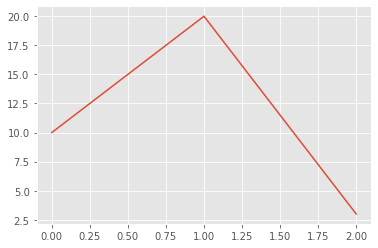

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot([0,1,2], [10,20,3])
fig.savefig('fig/to.png')   # save the figure to file
# plt.close(fig)    # close the figure window
# plt.show()